In [11]:
import numpy as np 
import matplotlib.pyplot as plt 
import joblib

import plotly.graph_objects as go
from sklearn.cluster import DBSCAN 


from cfl.cluster_methods.kmeans import KMeans
from cfl.experiment import Experiment
from visual_bars import generate_visual_bars_data as vbd
from cfl.util.data_processing import one_hot_encode
from cfl.dataset import Dataset
from cfl.visualization_methods import clustering_to_sankey as sk


In [2]:
# create a visual bars data set 

n_samples = 10000
noise_lvl = 0.0
im_shape = (10, 10)
random_seed = 143
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_seed)

ims = vb_data.getImages()
y = vb_data.getTarget()
 
# format data 
x = np.expand_dims(ims, -1)

y = one_hot_encode(y, unique_labels=[0,1])

Generating a visual bars dataset with 10000 samples at noise level 0.0


All results from this run will be saved to C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test\experiment0011
lr specified but not used by CondExpKC
opt_config not specified in input, defaulting to {}
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True
name not specified in input, defaulting to CondExpKC
standardize not specified in input, defaulting to False
best not specified in input, defaulting to True
Training CFL pipeline.
Epoch 1/5
235/235 [==============================] - 1s 5ms/step - loss: 0.1767 - val_loss: 0.1396
Epoch 2/5
235/235 [==============================] - 1s 2ms/step - loss: 0.1410 - val_loss: 0.1350
Epoch 3/5
235/235 [==============================] - 1s 4ms/step - loss: 0.1390 - val_loss: 0.1339
Epoch 4/5
235/235 [==============================] - 1s 3ms/step - loss: 0.1386 - val_loss: 0.1335
Epoch 5/5
235/235 [============================

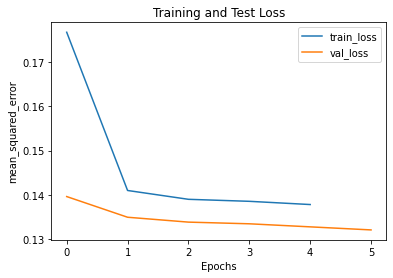

Loading parameters from  tmp_checkpoints/best_weights
Saving parameters to  C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test\experiment0011\trained_blocks\CondExpKC


In [3]:
lr = 1e-4 # this was 1e-3 in Chalupka's code
CDE_params = {  'batch_size': 32, # this was 10 in Chalupka's code
                    'lr': lr, 
                    'optimizer': 'adam', 
                    'n_epochs': 5, 
                    # 'standardize': True
                 }
data_info = {'X_dims': x.shape, 
             'Y_dims': y.shape, 
             'Y_type': 'categorical'}

block_names = ['CondExpKC']
block_params = [CDE_params]

# save_path = '/Users/imanwahle/Desktop/cfl/examples/exp_results'
save_path = 'C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test'
my_exp = Experiment(X_train=x, Y_train=y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, results_path=save_path)

results = my_exp.train()

In [4]:
pyx = results['CondExpKC']['pyx']

In [5]:
# pyx is n samples long, each subarray contains (P(Y=0), P(Y=1))
pyx[:10]

array([[0.32411325, 0.67588675],
       [0.9021772 , 0.09782274],
       [0.62083286, 0.37916714],
       [0.15848991, 0.84151006],
       [0.03237665, 0.9676233 ],
       [0.0519056 , 0.94809437],
       [0.0430648 , 0.9569352 ],
       [0.32411325, 0.67588675],
       [0.211166  , 0.78883404],
       [0.05639113, 0.9436088 ]], dtype=float32)

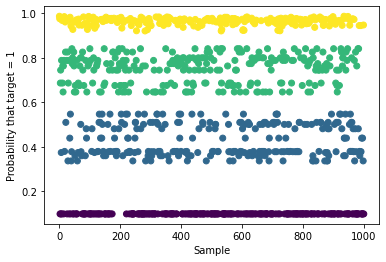

Average prediction for x-class 0: 0.10
Average prediction for x-class 1: 0.43
Average prediction for x-class 2: 0.76
Average prediction for x-class 3: 0.96


In [6]:

truth = vb_data.getGroundTruth()

#choose a thousand random samples from the pyx results 
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# plot them 
plt.scatter(range(1000), pyx[plot_idx,1], c=truth[plot_idx])
plt.ylabel("Probability that target = 1")
plt.xlabel("Sample")
plt.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i,1])))


In [7]:
# create a number of DBSCAN objects
eps_range = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]

cde_results_dict = results['CondExpKC']

dbscan_l = []
for n in eps_range:
  dbscan_obj = DBSCAN(eps=n)
  dbscan_l.append(dbscan_obj)

data = Dataset(x, y)

# trained all the data on the kmeanss 
x_lbls_L = []
for dbscan_obj in dbscan_l: 
  clustering = dbscan_obj.fit(pyx)
  x_lbls_L.append(clustering.labels_)

In [8]:
link, label = sk.convert_lbls_to_sankey_nodes(x_lbls_L)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])
    
fig.update_layout(title_text="Visual Bars (no noise) Clustering, DBSCAN, varying eps={}".format(eps_range), font_size=10)
fig.show()

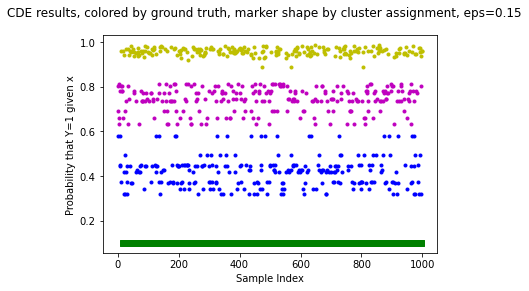

In [9]:
truth = vb_data.getGroundTruth()


# plot them 
markers = ["." , "," , "o" , "v" ]
colors = ['g','b', 'm', 'y']

#choose a thousand random samples from the pyx results 
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# for each sample 
for i in range(1000):  
    pi = pyx[plot_idx[i],1] # plot probability  
    mi = markers[x_lbls_L[3][plot_idx[i]]] #marker based on cluster assignment
    ci = colors[truth[plot_idx[i]]] #color based on ground truth class

    plt.scatter(i,pi, marker=mi, color=ci) 
plt.xlabel("Sample Index")
plt.ylabel("Probability that Y=1 given x")
plt.suptitle("CDE results, colored by ground truth, marker shape by cluster assignment, eps=0.15")
plt.show() 

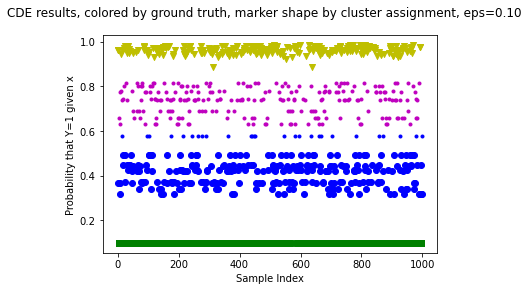

In [10]:
truth = vb_data.getGroundTruth()


# plot them 
markers = ["." , "," , "o" , "v", ">" ]
colors = ['g','b', 'm', 'y']

#choose a thousand random samples from the pyx results 
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# for each sample 
for i in range(1000):  
    pi = pyx[plot_idx[i],1] # plot probability  
    mi = markers[x_lbls_L[4][plot_idx[i]]] #marker based on cluster assignment
    ci = colors[truth[plot_idx[i]]] #color based on ground truth class

    plt.scatter(i,pi, marker=mi, color=ci) 
plt.xlabel("Sample Index")
plt.ylabel("Probability that Y=1 given x")
plt.suptitle("CDE results, colored by ground truth, marker shape by cluster assignment, eps=0.10")
plt.show() 


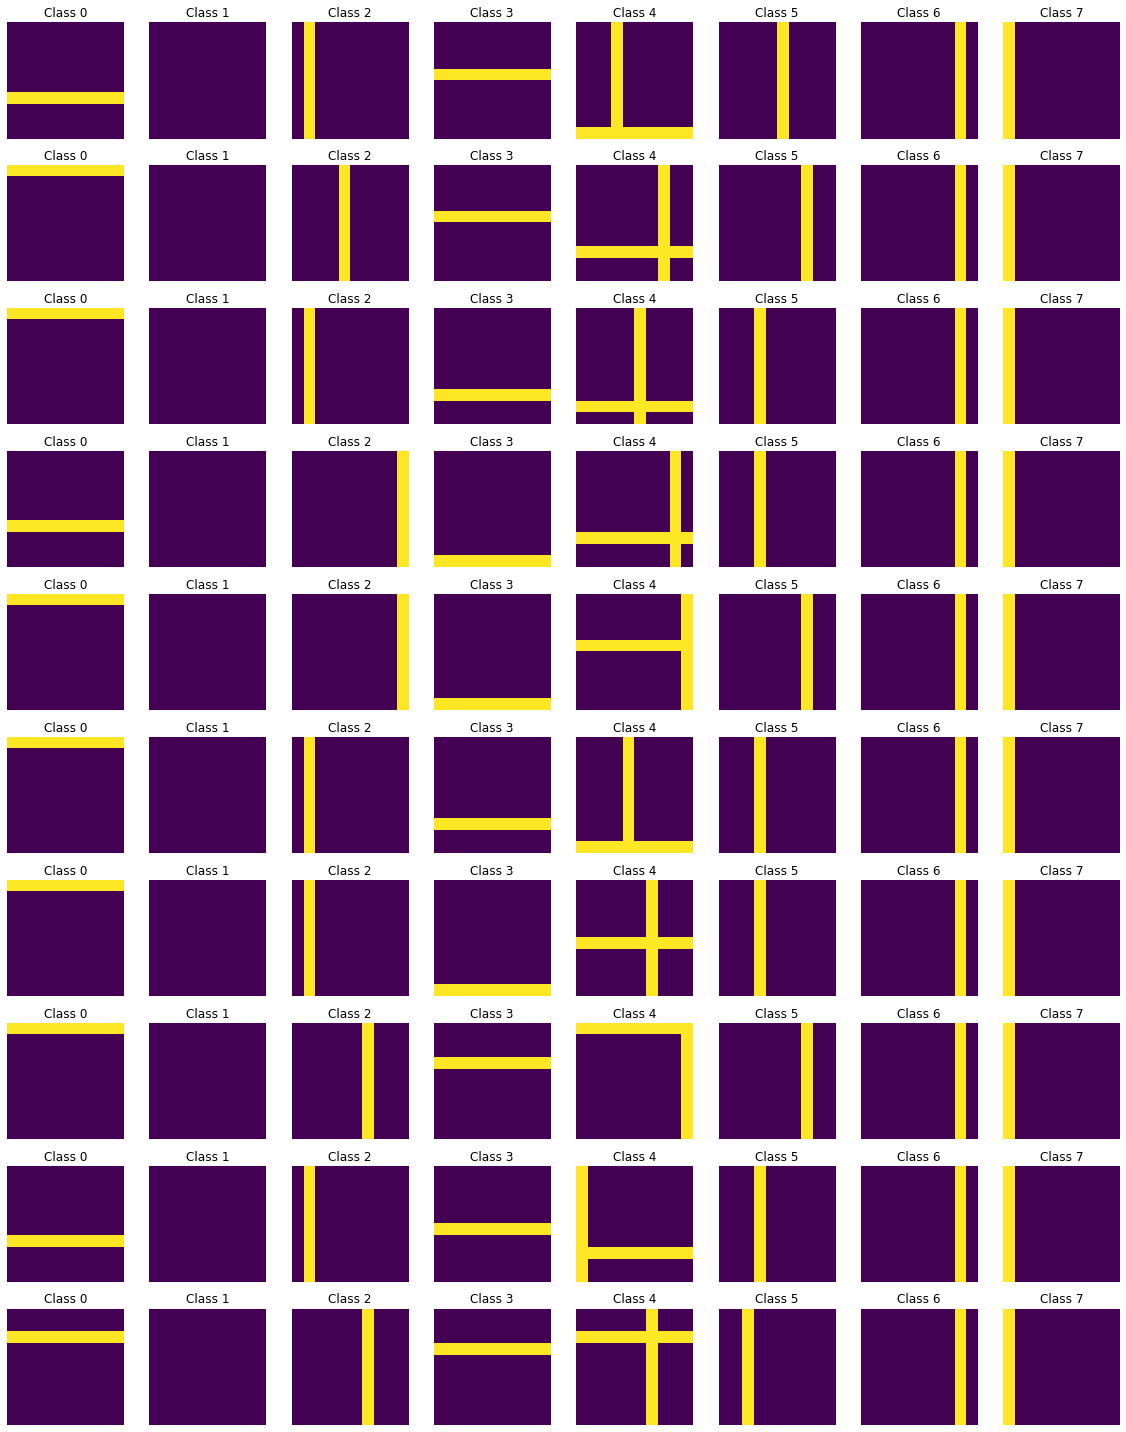

In [11]:
from cfl.visualization_methods import general_vis as vis
vis.view_class_examples(ims, im_shape, 10, x_lbls_L[5])

## With noisy data

Generating a visual bars dataset with 10000 samples at noise level 0.03
All results from this run will be saved to C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test\experiment0012
name not specified in input, defaulting to CondExpCNN
Training CFL pipeline.
Epoch 1/50
235/235 - 2s - loss: 0.2480 - val_loss: 0.2472
Epoch 2/50
235/235 - 2s - loss: 0.2239 - val_loss: 0.1891
Epoch 3/50
235/235 - 2s - loss: 0.1662 - val_loss: 0.1593
Epoch 4/50
235/235 - 2s - loss: 0.1512 - val_loss: 0.1527
Epoch 5/50
235/235 - 2s - loss: 0.1473 - val_loss: 0.1511
Epoch 6/50
235/235 - 2s - loss: 0.1458 - val_loss: 0.1497
Epoch 7/50
235/235 - 2s - loss: 0.1445 - val_loss: 0.1487
Epoch 8/50
235/235 - 2s - loss: 0.1433 - val_loss: 0.1475
Epoch 9/50
235/235 - 2s - loss: 0.1425 - val_loss: 0.1465
Epoch 10/50
235/235 - 2s - loss: 0.1412 - val_loss: 0.1455
Epoch 11/50
235/235 - 2s - loss: 0.1406 - val_loss: 0.1450
Epoch 12/50
235/235 - 3s - loss: 0.1398 - val_loss: 0.1443
Epoch 13/50
235/235 - 2s - loss: 0.13

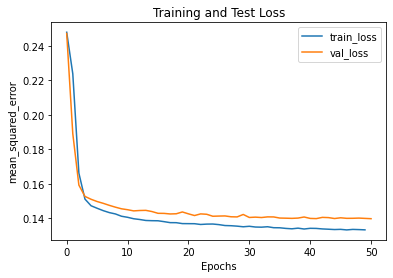

Loading parameters from  tmp_checkpoints/best_weights
Saving parameters to  C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test\experiment0012\trained_blocks\CondExpCNN


In [7]:
# create a visual bars data set 

n_samples = 10000
noise_lvl = 0.03
im_shape = (10, 10)
random_seed = 143
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))

vb_data2 = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_seed)

ims = vb_data2.getImages()
y = vb_data2.getTarget()
 
# format data 
x2 = np.expand_dims(ims, -1)

y2 = one_hot_encode(y, unique_labels=[0,1])

data_info = {'X_dims': x2.shape,
             'Y_dims': y2.shape,
             'Y_type': 'categorical'}

# # paragmeters for CDE
CNN_params = { # parameters for model creation
                    'filters'         : [32, 16],
                    'input_shape'     : (10, 10, 1),
                    'kernel_size'     : [(3, 3)] *2,
                    'pool_size'       : [(2, 2)] *2,
                    'padding'         : ['same'] *2,
                    'conv_activation' : ['softmax', 'softmax'],
                    'dense_units'     : 16,
                    'dense_activation' : 'softmax',
                    'output_activation': 'softmax',

                    # parameters for training
                    'batch_size'  : 32,
                    'n_epochs'    : 50,
                    'optimizer'   : 'adam',
                    'opt_config'  : {},
                    'verbose'     : 2,
                    'weights_path': None,
                    'loss'        : 'mean_squared_error',
                    'show_plot'   : True,
                    'standardize' : False,
                    'best'        : True,
                    }


block_names = ['CondExpCNN']
block_params = [CNN_params]

# save_path = '/Users/imanwahle/Desktop/cfl/examples/exp_results'
save_path = 'C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test'
my_exp2 = Experiment(X_train=x2, Y_train=y2, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, results_path=save_path)

results2 = my_exp2.train()

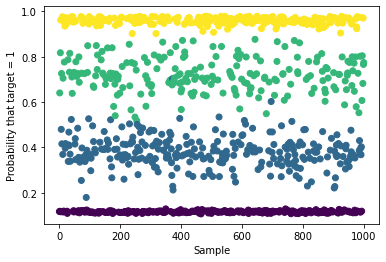

Average prediction for x-class 0: 0.12
Average prediction for x-class 1: 0.38
Average prediction for x-class 2: 0.72
Average prediction for x-class 3: 0.96


In [12]:
truth = vb_data.getGroundTruth()

pyx = results2['CondExpCNN']['pyx']

#choose a thousand random samples from the pyx results 
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# plot them 
plt.scatter(range(1000), pyx[plot_idx,1], c=truth[plot_idx])
plt.ylabel("Probability that target = 1")
plt.xlabel("Sample")
plt.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i,1])))


In [9]:
# create a number of DBSCAN objects
eps_range = (0.010, 0.008, 0.006, 0.004, 0.003, 0.002)

cde_results_dict = results2['CondExpCNN']

dbscan_l = []
for n in eps_range:
  dbscan_obj = DBSCAN(eps=n)
  dbscan_l.append(dbscan_obj)

data = Dataset(x, y)

# trained all the data on the kmeanss 
x_lbls_L = []
for dbscan_obj in dbscan_l: 
  clustering = dbscan_obj.fit(pyx)
  x_lbls_L.append(clustering.labels_)

NameError: name 'DBSCAN' is not defined

In [51]:
link, label = sk.convert_lbls_to_sankey_nodes(x_lbls_L)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])
    
fig.update_layout(title_text="Visual Bars (0.03 noise) Clustering, DBSCAN, varying eps={}".format(eps_range), font_size=8)
fig.show()

In [41]:
# Ideas:
# - varying other parameter gives ^4 clusters with little tiny clusters classified as noise?
# collect key plots (show ground truth checks) w lil description 

In [44]:
# SNN: put it on AWS?  (frederick will need to reset my password)
# might be better to start trying with noisy data? perfect categorical stuff might screw it up 
# 

# Vary MinPoints

In [72]:
# create a number of DBSCAN objects
minPoints_range = (1, 2, 3,4 , 5, 6, 7, 8, 9, 10, 11, 12)
eps = 0.003

cde_results_dict = results2['CondExpCNN']

dbscan_l = []
for n in minPoints_range:
  dbscan_obj = DBSCAN(eps=eps, min_samples=n)
  dbscan_l.append(dbscan_obj)

data = Dataset(x, y)

# trained all the data on the kmeanss 
x_lbls_L = []
for dbscan_obj in dbscan_l: 
  clustering = dbscan_obj.fit(pyx)
  x_lbls_L.append(clustering.labels_)

In [69]:
np.unique(x_lbls_L[0])

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype=int64)

In [73]:
link, label = sk.convert_lbls_to_sankey_nodes(x_lbls_L)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])
    
fig.update_layout(title_text="Visual Bars (0.03 noise) Clustering, DBSCAN, varying min_samples={}".format(minPoints_range), font_size=8)
fig.show()

# Vary order of pyxs

In [44]:
import random 

# create a number of DBSCAN objects
minPoints = 5 
eps = 0.003

cde_results_dict = results2['CondExpCNN']

dbscan_l = []
for n in range(10):
  dbscan_obj = DBSCAN(eps=eps, min_samples=minPoints)
  dbscan_l.append(dbscan_obj)

data = Dataset(x, y)

shuffled_indices_L = []
# trained all the data on the kmeanss 
shuffled_x_lbls_L = []
for dbscan_obj in dbscan_l:
    #shuffle order of elements in pyx 
    # save the shuffled indices so that you know the order 
    indices = list(range(len(pyx)))
    zipped = list(zip(indices, pyx) )
    random.shuffle(zipped) 

    shuffled_inds, shuffled_pyx = zip(*zipped)
    shuffled_indices_L.append(shuffled_inds)
    clustering = dbscan_obj.fit(shuffled_pyx)
    shuffled_x_lbls_L.append(clustering.labels_)


#unshuffle results 
x_lbls_L = []
for i, indices in enumerate(shuffled_indices_L): 
    sorted_inds, sorted_labels = (list(x) for x in zip(*sorted(zip(indices, shuffled_x_lbls_L[i]))))
    x_lbls_L.append(np.array(sorted_labels))


In [45]:
link, label = sk.convert_lbls_to_sankey_nodes(x_lbls_L)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])
    
fig.update_layout(title_text="Visual Bars (0.03 noise) Clustering, DBSCAN, shuffling P(y|x) each time, with fixed params: minPts={}, eps={}".format(minPoints, eps), font_size=8)
fig.show()